# Genomic Discovery to Translation: Matching Drugs to Disease Subtypes with DiSCoVER

**Notebook Authors**: Edwin F. Juárez and Pablo Tamayo  
**Author email:** ejuarez@ucsd.edu -- *Feel free to post questions on the [GenePattern help forum: http://genepattern.org/help](https://groups.google.com/forum/#!forum/genepattern-help).*  

This notebook utilizes the DiSCoVER algorithm [[1]](#References) to identify compounds that target a specific disease subtype.

<!--This notebook was developed to help with the data analyses of a pediatric neuro-oncology molecular tumor board. -->

<div class="alert alert-danger">
<h3 style="margin-top: 0;"> For Research Purposes Only <i class="fa fa-exclamation-circle"></i></h3>
    
This notebook is a genomics research tool to discover associations between disease subtypes and drug sensitivities. <b>It is not intended to be used with clinical datasets or as part of any clinical-based analysis of any type.</b>
</div>

<div class="alert alert-danger">
<h3 style="margin-top: 0;"> PHI Notice <i class="fa fa-exclamation-circle"></i></h3>
    
<b>Protected Health Information:</b> By registering for GenePattern/GenePattern Notebook, you agree that you will upload only information that can be made available for public consumption and for which you have specific permission.  Do not upload information that identifies specific individuals or that can be associated with them, known as Personally Identifiable Information (PII).  If you have any doubts as to whether specific information can be uploaded, please consult the Compliance Office in your institution. The Regents of the University of California do not accept any responsibility or liability for any information that you upload that is prohibited above.

</div>

<div class="alert alert-warning">
<h3 style="margin-top: 0;"> Technical note <i class="fa fa-exclamation-triangle"></i></h3>
    
This notebook is in beta version (i.e., it is under continous development). Expect changes to the public version of this notebook. It contains a beta version of the DiSCoVER module which currently can only be run in our server. If you download this notebook to run on a local server, DiSCoVER will not be able to run successfully.  

This notebook utilizes gene expression and drug sensitivity datasets from the Broad’s DepMap (CCLE and CTRP) and Sanger (GDSC, SCLP). The original datasets are available from the URL’s listed in the references at the end of the notebook [[2-4]](#References).
</div>

In [4]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

### Background & workflow

The general flow of this notebook is as follows:  
- Provide Disease Subtype samples expression data.
- Provide Control samples expression data.
- Run DiSCoVER
- Display the best scoring compounds that DiSCoVER found.

For a detailed explanation of the DiSCoVER algorithm, refer to [[1]](#References). In broad strokes, DiSCoVER first takes the gene expression data from disease subtype samples vs. controls and performs differential gene expression in order to generate a disease signature (gene set). Then the enrichment profiles of this signature, across the samples of two gene expression datasets (CCLE, SCLP), are computed using single-sample GSEA [(Barbie et al. 2009)](#References). The enrichment profiles are then matched, using the Information Coefficient (IC, [Kim et al. 2016](#References)) and independently in each dataset, against the sensitivity profiles of the CTRP and Sanger drug screens over the cell lines where the expression and sensitivity datasets overlap. Finally, drugs are ranked based on these matching scores: a high score means that the enrichment profile of the disease signature matches the sensitivity profile of the drug.

<div class="alert alert-danger">   
<i class="fa fa-exclamation-triangle"></i> Please note that in this notebook the user needs to provide the gene expression input datasets for the disease subtype and control samples. The results are highly dependent on the choice of control and therefore careful thought should be given to this choice.
</div>

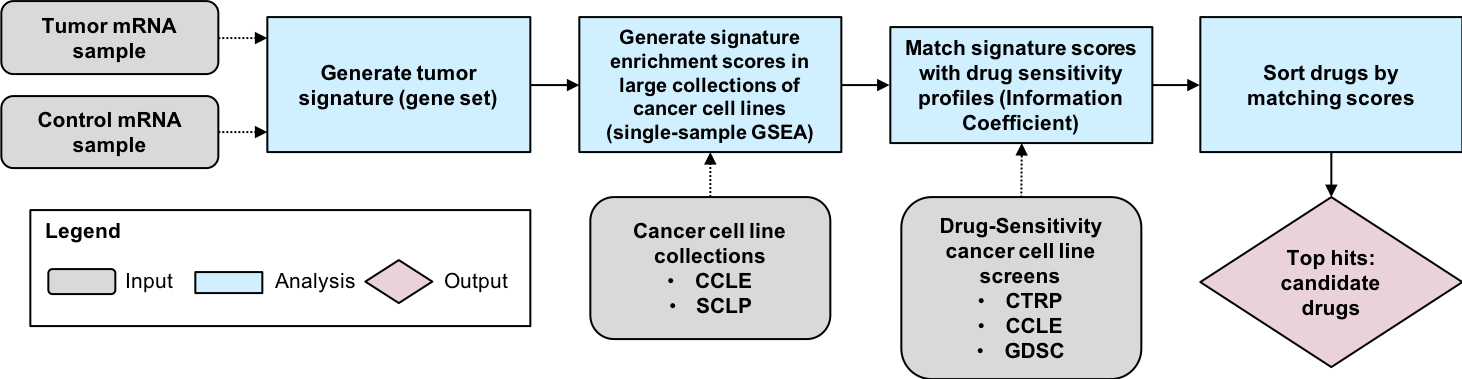

Application note: we are exploring the use of DiSCoVER-like methods to target several types of brain cancers at Rady Children's hospital in San Diego.

# Generate Top Scoring Drugs with DiSCoVER

In this step we use the DiSCoVER GenePattern module to identify compounds which may target the disease subtype represented by the input samples. The controls need to be carefully chosen to represent e.g. cell of origin normal tissue, another disease subtype(s) or a proper cellular context to contrast the disease subtype.

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>

- Provide the disease subtype gene expression as a CSV file (formatted as described in technical details).
- Provide the control gene expression as a CSV file (formatted as described in technical details).
- As an example run you can use these files containing sample data ([BRCA tumor samples](https://datasets.genepattern.org/data/module_support_files/DiSCoVER/TCGA-A7-A0CE-01.csv) and [normal Breast from TCGA](https://datasets.genepattern.org/data/module_support_files/DiSCoVER/TCGA-A7-A0CE-11.csv)).
- Choose whether to display supplementary files.
</div>

In [5]:
discover_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00393')
discover_job_spec = discover_task.make_job_spec()
discover_job_spec.set_parameter("gene_expression", "")
discover_job_spec.set_parameter("is_medulloblastoma", "False")
discover_job_spec.set_parameter("use_custom_control", "True")
discover_job_spec.set_parameter("control", "")
discover_job_spec.set_parameter("output_supplementary_files", "False")
discover_job_spec.set_parameter("job.memory", "2 Gb")
discover_job_spec.set_parameter("job.queue", "gp-cloud-default")
discover_job_spec.set_parameter("job.cpuCount", "1")
discover_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(discover_task)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00393')

# Create a table summarizing DiSCoVER's results

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
  
- For the parameter **DiSCoVER output CSV file**, click on the drop down menu and select the CSV file that DiSCoVER outputs.
- For the parameter **number of drugs**, indicate how many drugs to display (10 by default).
</div>

In [3]:
import pandas as pd
from io import StringIO
import nbtools
import numpy as np

##### Before DiSCoVER
def split_discover_dataframe(df, min_score=0):
    # This is super inefficient for larger DataFrames, but let's worry about efficiency later

    out = pd.DataFrame(columns=['moa','GDSC','CTRP','CCLE','drug'])

    for index, row in df.iterrows():
        dataset = row['drug'].split('_')[0].lower()
        drug = row['drug'].split('_')[1].lower()

        if dataset == 'gdsc':
            out.loc[drug,'GDSC'] = row['score']
        elif dataset == 'ctrp':
            out.loc[drug,'CTRP'] = row['score']
        elif dataset == 'ccle':
            out.loc[drug,'CCLE'] = row['score']
        out.loc[drug,'drug'] = row['drug']
        out.loc[drug,'moa'] = row['moa']

    #     df['database'] = [drug.split('_')[0].upper() for drug in df['drug']]
    #     df['drug'] = [drug.split('_')[1].lower() for drug in df['drug']]
    #     df = df[df['score']>0]  # It feels inneficient to do this last, but Pandas complaints if I do it earlier.
    #     out = df[~df['drug'].duplicated(keep='first')].drop('score', axis=1,inplace=False)
    #     out['Drug'] = np.unique([drug.split('_')[1].lower() for drug in df['drug']])
    return out

sign_to_letter = {
    1:"+",
    -1:"-",
    '1.0':"+",
    '-1.0':"-",
    'nan':'.',
    '0.0':'.',
    '0':'.',
    0:'.',
}

annotation = {
    "motesanib":"VEGFR inhibitor, receptor tyrosine kinase inhibitor, PDGFR inhibitor, Kit inhibitor, Ret receptors inhibitor, Cell proliferation inhibitor",
    'cetuximab':"EGFR inhibitor",
    'gw-2580':"Tyrosine Kinase inhibitor",
    'dabrafenib':'BRAF inhibitor',
    'cyclopamine':'glioma-associated oncogene inhibitor',
    'rucaparib':'PARP inhibitor',
    'plx-4720':'BRAF inhibitor',
}

def supporting_evidence(row):
    # assuming only three columns
    return sign_to_letter[str(np.sign(row[0]))]+sign_to_letter[str(np.sign(row[1]))]+sign_to_letter[str(np.sign(row[2]))]


def rank_drugs_discover(df):
    df['score'] = df.drop(['moa','drug'],axis=1,inplace=False).mean(axis=1,skipna=True).round(3)
    df['evidence'] = df.drop(['moa','score'],axis=1).apply(supporting_evidence, axis=1)
    return df.sort_values(by=['score'],ascending=False,axis=0)

def make_clickable(url):
    to_display = url.split('=')[1]
    return '<a href="{}" target="_blank">{}</a>'.format(url, to_display)



@nbtools.build_ui(
        name="Make table summarizing drug recommendations",
        description='Create an easy to read table based on the output from DiSCoVER.',
        parameters={
                    "GP_csv": {  "name": "DiSCoVER output CSV file",
                                 "type": "file",
                                 "kinds": ["csv","CSV"],
                                 "description":"The output from DiSCoVER",
                            },
                   "number_of_drugs": {"default":10},
                   "output_var": {"default":"drug_df"},
                })
def make_table(GP_csv:'URL of the CSV output from DiSCoVER',
               number_of_drugs:'How many drugs to report'=10,
              ):
    uio = nbtools.UIOutput(name='Example Output',status='Running!')
    
    try: 
        drug_df = pd.read_csv(GP_csv,index_col=0)
    except:
        uio.status = 'Fetching csv file...'
        # Get the job number and name of the file
        temp = GP_csv.split('/')
        # programatically access that job to open the file
        GP_csv = eval('job'+temp[5]+'.get_file("'+temp[6]+'")')
        drug_df = pd.read_csv(StringIO(GP_csv.read()),index_col=0)
    
    drug_df['drug'] = drug_df.index

    df = split_discover_dataframe(df=drug_df)
    df = rank_drugs_discover(df).drop('drug',axis=1)
    df.index.name = 'Drug'
    df['Pubchem link']=pd.Series(["https://pubchem.ncbi.nlm.nih.gov/#query={}".format(drug) for drug in df.index.values], index=df.index)
    df['Manual annotation']=pd.Series([annotation[drug] if drug in annotation.keys() else 'N/A' for drug in df.index.values], index=df.index)
    
    annotation
    styled_df = df.head(number_of_drugs).fillna('N/A').style.format({'Pubchem link': make_clickable})
    
    uio.status = 'Formatting csv file..'
    display(styled_df)
#     print("N/A* means that this drug is not present in this repository")
    return df

UIBuilder(description='Create an easy to read table based on the output from DiSCoVER.', function_import='make…

# References

1. Hanaford, A. R., Archer, T. C., Price, A., Kahlert, U. D., Maciaczyk, J., Nikkhah, G., … Raabe, E. H. (2016). DiSCoVERing Innovative Therapies for Rare Tumors: Combining Genetically Accurate Disease Models with In Silico Analysis to Identify Novel Therapeutic Targets. Clinical cancer research : an official journal of the American Association for Cancer Research, 22(15), 3903–3914. [doi:10.1158/1078-0432.CCR-15-3011](https://clincancerres.aacrjournals.org/content/early/2016/06/15/1078-0432.CCR-15-3011)  
1. CCLE:
https://www.nature.com/articles/nature11003
Barretina J, Caponigro G, Stransky N, Venkatesan K, Margolin AA, Kim S, et al. The Cancer Cell Line Encyclopedia enables predictive modelling of anticancer drug sensitivity. Nature 2012;483:603–7.  
1. GDSC: 
https://academic.oup.com/nar/article/41/D1/D955/1059448
Yang W, Soares J, Greninger P, Edelman EJ, Lightfoot H, Forbes S, et al. Genomics of Drug Sensitivity in Cancer (GDSC): a resource for therapeutic biomarker discovery in cancer cells. Nucleic Acids Res 2013;41:D955–61  
1. CTRP: 
https://cancerdiscovery.aacrjournals.org/content/5/11/1210.short
Seashore-Ludlow B, Rees MG, Cheah JH, Cokol M, Price EV, Coletti ME, et al. Harnessing connectivity in a large-scale small-molecule sensitivity dataset. Cancer Discov 2015;5:1210–23  
1. Barbie et al. 2009: Barbie D. et al. Systematic RNA interference reveals that oncogenic KRAS-driven cancers require TBK1. Nature. 2009 Nov 5;462(7269).  
1. Kim et al. 2016:  Kim, W. et al. Characterizing genomic alterations in cancer by complementary functional associations. Nat Biotechnol. 2016 May;34(5):539-46.

# Appendix

#### Technical details

<div class="well well-sm">
    
*The modules used in this notebook are under constant development, these are early releases. For any questions or request for features, email Edwin <ejuarez@ucsd.edu> or post on the [GenePattern help forum](https://groups.google.com/forum/#!forum/genepattern-help)*
</div>

Two of the inputs of the DiSCoVER module are gene expression files formatted as CSV. These can be generated using Kallisto or manually by ensuring the CSV files meet the requirements below.

There are two acceptable formats for these CSV files:

1- "Wide" CSV (as created by the Kallisto module). This CSV must have 2 rows and multiple columns. The element on the first column and first row is not used so it can be left blank. The element on the first column and second row will be the name of the sample. The rest of the columns contain paired information: on the first row the gene name and on the second row the quantified gene expression.

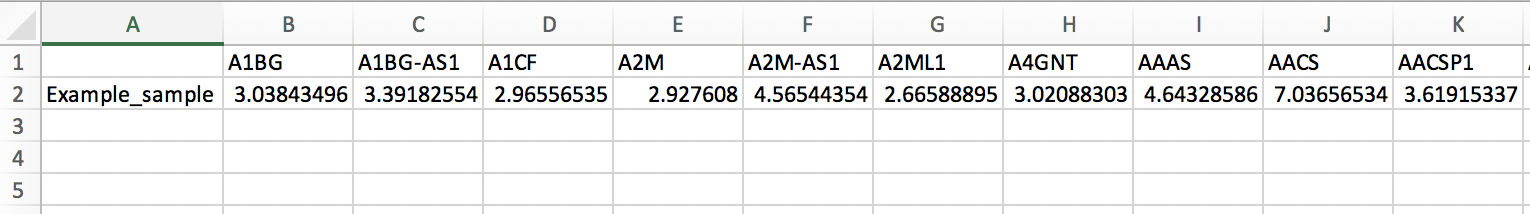

2- "Tall" CSV. This CSV must have **three** columns and multiple rows. The elements on the first row and the first and second column are not used so they can be left blank. The element on the first row and third column will be the name of the sample. The rest of the rows contain three pieces of information: the index on the first column, the name of the gene on the second column, and the quantified gene expression on the third column.

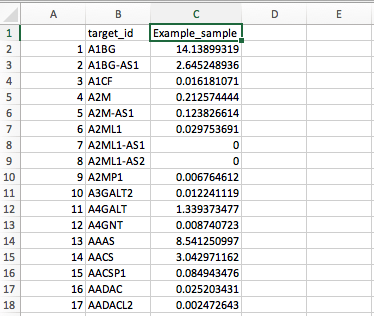

*Note: if you find an issue with the formatting of the input files, reffer to the module's documentation: https://github.com/genepattern/DiSCoVER/blob/develop/DiSCoVER_documentation.md or contact the developer.*